In [0]:
import numpy as np
import pandas as pd
from plotnine import *
from pandas import DataFrame
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


def get_classification_groups(y, y_pred):
    y, y_pred = y.astype(bool), y_pred.astype(bool)

    group = np.repeat('  ', len(y))
    group[np.where(y  &  y_pred)] = "TP"
    group[np.where(y  & ~y_pred)] = "FN"
    group[np.where(~y &  y_pred)] = "FP"
    group[np.where(~y & ~y_pred)] = "TN"
    return group, np.isin(group, ["TP", "TN"])
    
    
def fit(x, y, depth):
    model = DecisionTreeClassifier(max_depth = depth).fit(x, y)
    y_pred = model.predict(x)
    group, correct_class = get_classification_groups(y, y_pred)
    
    df = DataFrame({'x1':x[:,0], 'x2':x[:, 1], 'class':y, 'pred': y_pred, 
                    'correct': correct_class, 'group': group, 'set': 'Train', 'depth': depth, 
                    'accuracy': model.score(x, y), 'error': round(1 - model.score(x, y), 4)})
    return model, df
    
    
def test_model(model, x, y, depth):
    y_pred = model.predict(x)
    group, correct_class = get_classification_groups(y, y_pred)
    return DataFrame({'x1':x[:,0], 'x2':x[:, 1], 'class':y, 'pred': y_pred, 
                      'correct': correct_class, 'group': group, 'set': 'Test', 'depth': depth, 
                      'accuracy': model.score(x, y), 'error': round(1 - model.score(x, y), 4)})


def space_partitioning(model, x, depth):
    #or visualization, we would like to see the different partitions the classification tree
    # created. For that we create a 2D grid uniformly spread over R^2 of points. There points are to 
    # be classified by the fitted tree, and will be used to show the decision boundaries
    margin = 1.5
    x1_grid, x2_grid = np.meshgrid(np.linspace(x[:, 0].min() - margin, x[:, 0].max() + margin, 100),
                                   np.linspace(x[:, 1].min() - margin, x[:, 1].max() + margin, 100))
    partitioning = np.c_[x1_grid.ravel(), x2_grid.ravel()]
    partitioning_class = model.predict(partitioning)
    
    #To keep the save format as  the other dataframes we fill in Nones   
    return DataFrame({'x1': partitioning[:, 0], 'x2': partitioning[:, 1], 'class': [None]*len(partitioning),
                      'pred': partitioning_class, 'correct': [None]*len(partitioning), 
                      'group': [None]*len(partitioning), 'set': 'Partition', 'depth': depth,
                      'accuracy': [None]*len(partitioning), 'error': [None]*len(partitioning)})
    

# Fit Shallow Decision Tree to Easy Data 

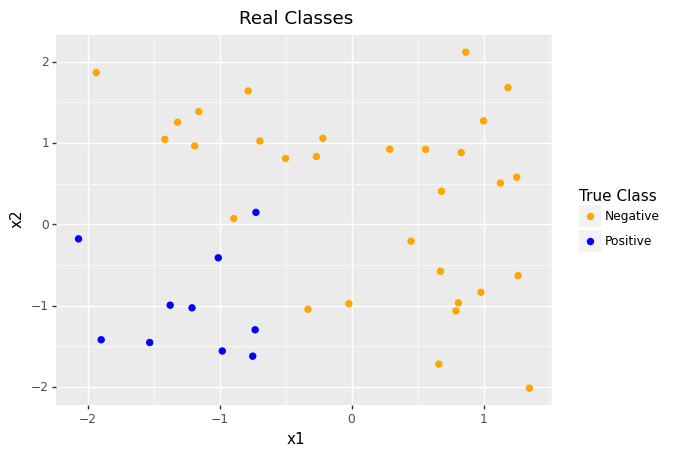

<ggplot: (8793913656566)>

In [14]:
np.random.seed(2)
m = 10

# Sampling `m` data-points around each center point, labeling the first group of points as `0` and the rest as `1`.
X = np.concatenate([np.random.normal(point, .5, size=(m, 2)) 
                    for point in [[-1, -1], [1, 1], [-1, 1], [1, -1]]])
Y = np.concatenate((np.ones(m), np.zeros(m * 3))).astype(bool)

model, df = fit(X, Y, 1)

(ggplot(df[df.set == "Train"], aes(x='x1', y='x2', color='class')) +
 geom_point(size=2) + 
 labs(title="Real Classes", color="True Class") + 
 scale_color_manual(values=["orange", "blue"], labels=["Negative", "Positive"]))




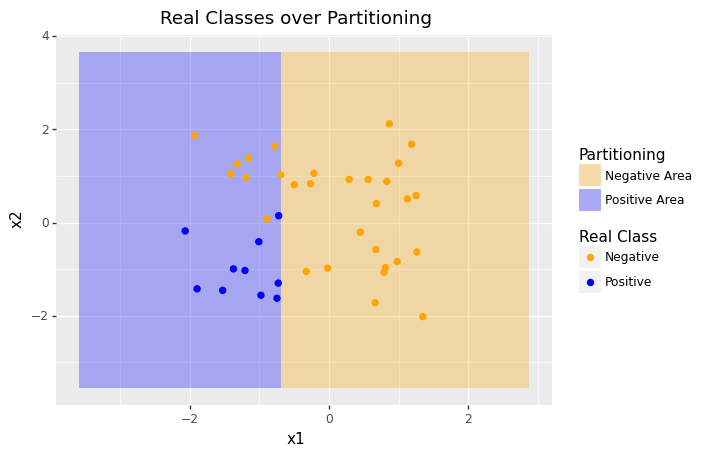

<ggplot: (8793913650429)>

In [15]:
df = pd.concat([df, space_partitioning(model, X, 1)])
(ggplot(df[df.set == "Train"], aes(x="x1", y="x2")) +
 geom_tile(df[df.set == "Partition"], aes(fill="pred"), alpha=.3) + 
 geom_point(aes(color='class'), size=2) +
 labs(title="Real Classes over Partitioning", color="Real Class", fill="Partitioning") + 
 scale_fill_manual(values=["orange", "blue"],  labels=["Negative Area", "Positive Area"]) + 
 scale_color_manual(values=["orange", "blue"],  labels=["Negative", "Positive"]))
 
 
 
 

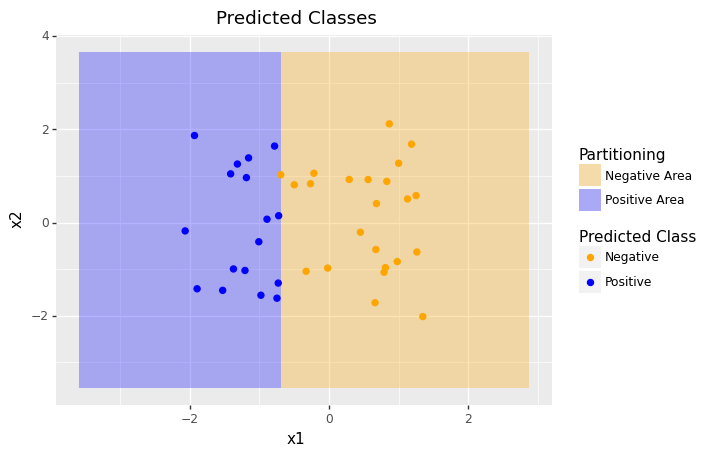

<ggplot: (8793913648981)>

In [16]:
(ggplot(df[df.set == "Train"], aes(x="x1", y="x2")) +
 geom_tile(df[df.set == "Partition"], aes(fill="pred"), alpha=.3) + 
 geom_point(aes(color='pred'), size=2) +
 labs(title="Predicted Classes", color="Predicted Class", fill="Partitioning") + 
 scale_fill_manual(values=["orange", "blue"],  labels=["Negative Area", "Positive Area"]) + 
 scale_color_manual(values=["orange", "blue"],  labels=["Negative", "Positive"]))
 
 
 
 

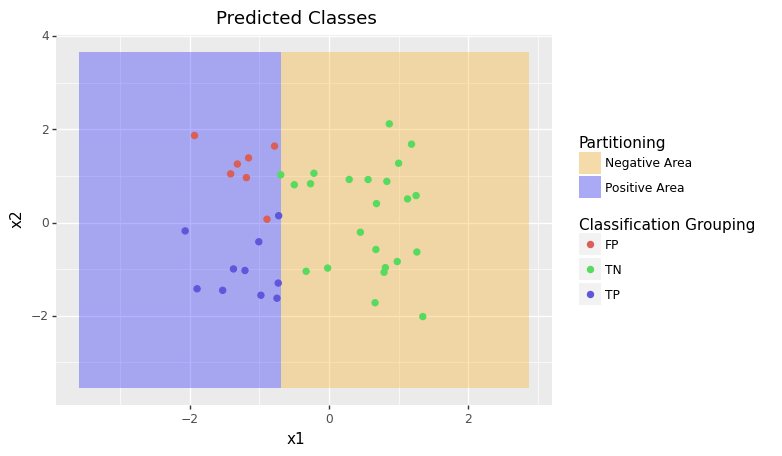

<ggplot: (8793913571830)>

In [17]:
(ggplot(df[df.set == "Train"], aes(x='x1', y='x2')) +
 geom_tile(df[df.set == "Partition"], aes(fill="pred"), alpha=.3) + 
 geom_point(aes(color='group'), size=2) +
 labs(title="Predicted Classes", color="Classification Grouping", fill="Partitioning") + 
 scale_fill_manual(values=["orange", "blue"],  labels=["Negative Area", "Positive Area"]))




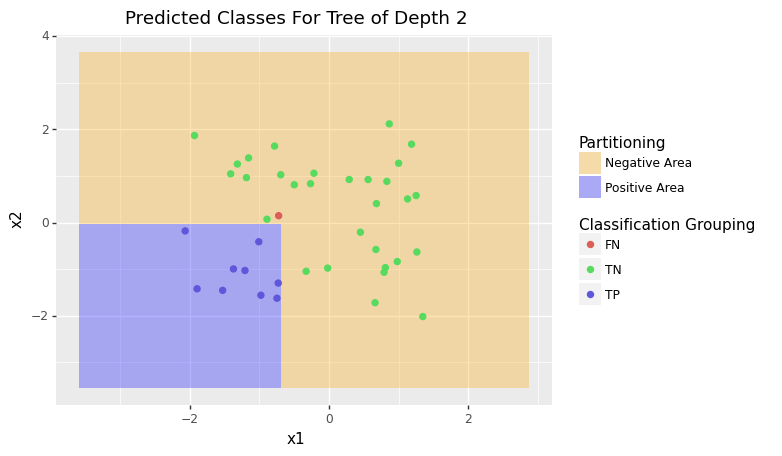

<ggplot: (-9223363242941193917)>

In [18]:
# Next we fit a tree of deeper depth (2) and revisit plots above
model, df = fit(X, Y, 2)
df = pd.concat([df, space_partitioning(model, X, 2)])

(ggplot(df[df.set == "Train"], aes(x='x1', y='x2')) +
 geom_tile(df[df.set == "Partition"], aes(fill="pred"), alpha=.3) + 
 geom_point(aes(color='group'), size=2) +
 labs(title="Predicted Classes For Tree of Depth 2", color="Classification Grouping", fill="Partitioning") + 
 scale_fill_manual(values=["orange", "blue"],  labels=["Negative Area", "Positive Area"]))




# Evaluating Trees of Different Depth for Complex Data

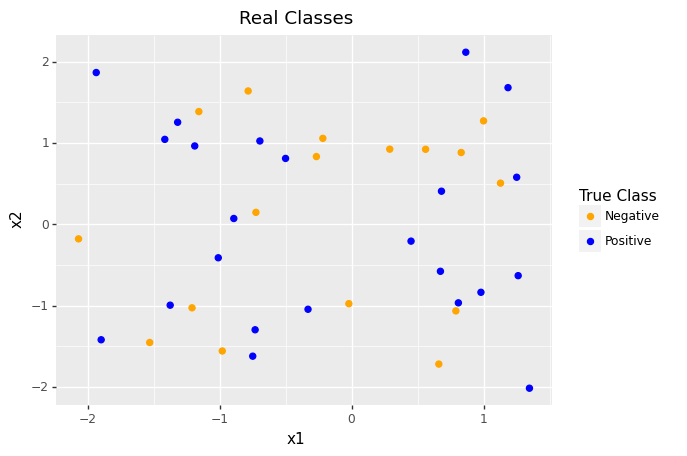

<ggplot: (8793919083170)>

In [19]:
# In the next steps we will simulate data that is less easy to classify, as labels are more mixed.
# For simplicity we just use the previously simulated feature values and only change the labeling
Y = np.random.randint(2, size= 4*m).astype(bool)

m, df = fit(X, Y, 1)

(ggplot(df[df.set == "Train"], aes(x='x1', y='x2', color='class')) +
 geom_point(size=2) + 
 labs(title="Real Classes", color="True Class") + 
 scale_color_manual(values=["orange", "blue"], labels=["Negative", "Positive"]))




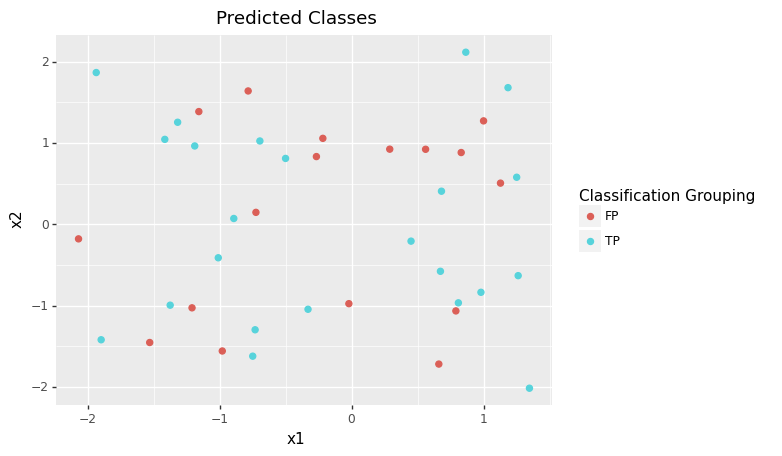

<ggplot: (-9223363242941119456)>

In [20]:
(ggplot(df[df.set == "Train"], aes(x='x1', y='x2')) +
 geom_point(aes(color='group'), size=2) +
 labs(title="Predicted Classes", color="Classification Grouping"))  


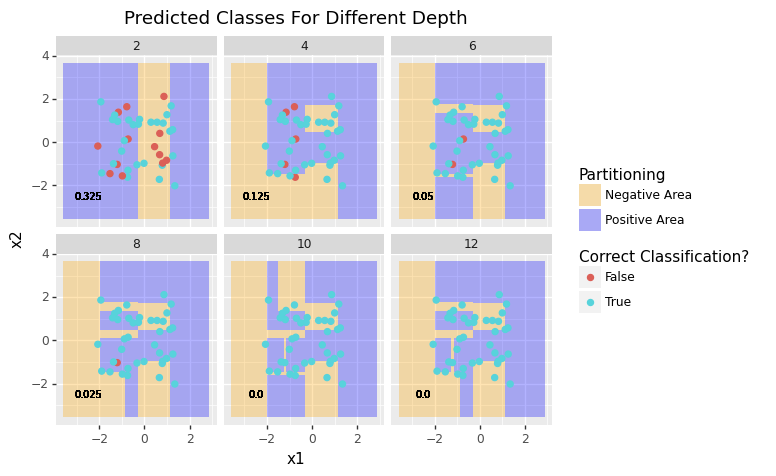

<ggplot: (8793923272298)>

In [21]:
df = []
for k in [2, 4, 6, 8, 10, 12]:
    m, df_k = fit(X, Y, k)
    df.extend([df_k, space_partitioning(m, X, k)])
df = pd.concat(df)

(ggplot(df[df.set == "Train"], aes(x="x1", y="x2")) +
 geom_tile(df[df.set == "Partition"], aes(fill="pred"), alpha=.3) + 
 geom_point(aes(color='correct'), size=2) +
 geom_text(aes(label="error"), x=-2.5, y=-2.5, size=7) +
 labs(title="Predicted Classes For Different Depth", color="Correct Classification?", fill="Partitioning") + 
 scale_fill_manual(values=["orange", "blue"],  labels=["Negative Area", "Positive Area"]) + 
 facet_wrap("~depth"))



# Over-fitting & Bias-Variance

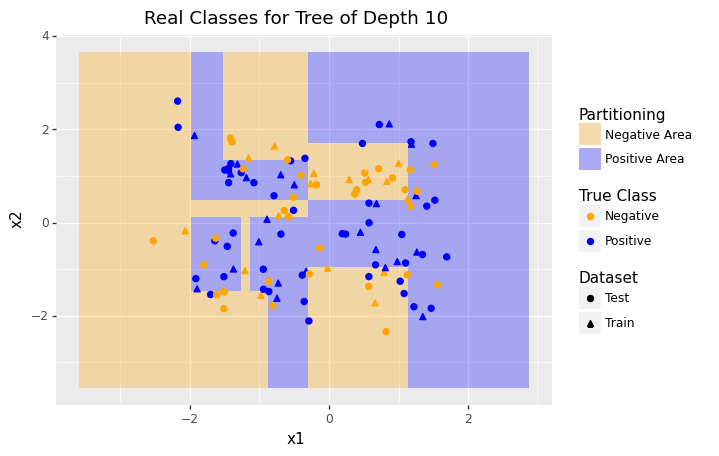

<ggplot: (8793913561285)>

In [22]:
testX = np.concatenate([np.random.normal(X, .3), np.random.normal(X, .3)])
testY = np.concatenate([Y,Y])

# In the following part we will observe the case of overfitting. The tree of depth <=10 achieved 100% accuracy. 
# We will next evaluate its performance over a test set that is similar to the original data but isn't exactly the same
m, df = fit(X, Y, 10)
partitionDF = space_partitioning(m, X, 10)
testDF = test_model(m, testX, testY, 10)


df = pd.concat([df, partitionDF, testDF])

#Just as a reminder, this is how our training- and test data is spread
(ggplot(df[df.set != "Partition"], aes(x='x1', y='x2')) +
 geom_tile(df[df.set == "Partition"], aes(fill="pred"), alpha=.3) +
 geom_point(aes(color="class", shape="set"), size=2) + 
 labs(title="Real Classes for Tree of Depth 10", color="True Class", fill="Partitioning", shape="Dataset") + 
 scale_fill_manual(values=["orange", "blue"],  labels=["Negative Area", "Positive Area"]) +
 scale_color_manual(values=["orange", "blue"], labels=["Negative", "Positive"]))




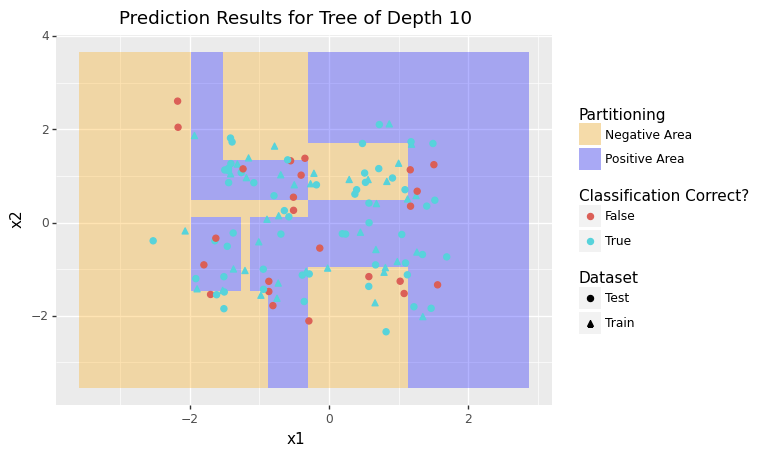

<ggplot: (-9223363242935841981)>

In [23]:
(ggplot(df[df.set != "Partition"], aes(x='x1', y='x2')) +
 geom_tile(df[df.set == "Partition"], aes(fill="pred"), alpha=.3) +
 geom_point(aes(color="correct", shape="set"), size=2) + 
 labs(title="Prediction Results for Tree of Depth 10", color="Classification Correct?", fill="Partitioning", shape="Dataset") + 
 scale_fill_manual(values=["orange", "blue"],  labels=["Negative Area", "Positive Area"]))




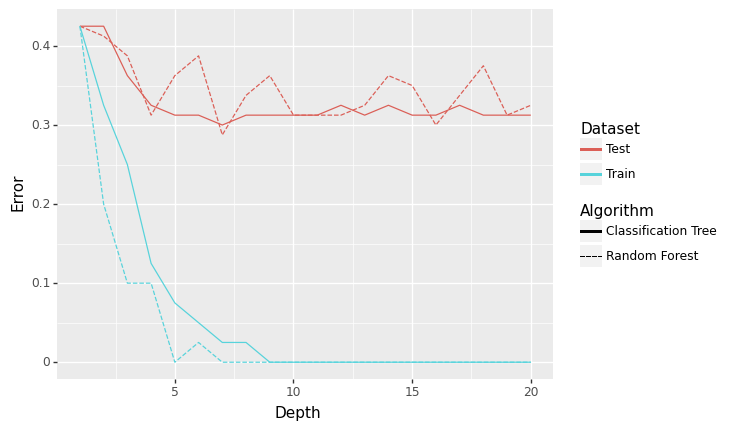

<ggplot: (-9223363242942267953)>


In [65]:
#Implement the following function. Do not use the function defined at the beginning of the file

def fit_tree_and_test(trainX, trainY, testX, testY, ks):
    """
    Train a classification tree for each given depth and test its performance
    :param trainX: sample features to train on 
    :param trainY: sample true labels to train on
    :param testX: sample features to test on
    :param testY: sample true labels to test on
    :param ks: A collection of depth values. Train a model for each
    :return: A data frame with the following columns: Depth, Dataset, Algorithm, Error.
        1) Values of "Algorithm" columns should be "Classification Tree"
        2) For every k given in ks, the output dataframe should have 2 rows: one over the train, 
           and one over the test. (Make sure to properly set the values of the "Dataset" column)
        3) All together the dataframe should have 2*|ks| records
    Implementation hint: for every k in ks, create a DataFrame with the two needed rows. 
    Then use pandas.concat to bind all of the dfs (This is just an implementation tip - you can
    implement in any other way that you might prefer)
    """
    df = []
    for k in ks:
      #  train on train set:
      model = DecisionTreeClassifier(max_depth = k).fit(trainX, trainY)
       
      #  predict on test set:
      y_pred = model.predict(testX) 
      
      #  present it all in a df:
      df_k = DataFrame({'Dataset': ['Train', 'Test'],
                      'Error': [round(1 - model.score(trainX, trainY), 4), round(1 - model.score(testX, testY), 4)], 
                      'Algorithm':'Classification Tree', 'Depth': k})
      df.extend([df_k])

    
    df = pd.concat(df)
    return df


def fit_forest_and_test(trainX, trainY, testX, testY, ks):
    """
    Train a random forest model for each given depth and test its performance
    :param trainX: sample features to train on 
    :param trainY: sample true labels to train on
    :param testX: sample features to test on
    :param testY: sample true labels to test on
    :param ks: A collection of depth values. Train a model for each
    :return: A data frame with the following columns: Depth, Dataset, Algorithm, Error.
        1) Values of "Algorithm" columns should be "Random Forest"
        2) For every k given in ks, the output dataframe should have 2 rows: one over the train, 
           and one over the test. (Make sure to properly set the values of the "Dataset" column)
        3) All together the dataframe should have 2*|ks| records
    Implementation hint: for every k in ks, create a DataFrame with the two needed rows. 
    Then use pandas.concat to bind all of the dfs (This is just an implementation tip - you can
    implement in any other way that you might prefer)
    """
    df = []
    for k in ks:
      #  train on train set:
      model = RandomForestClassifier(max_depth = k).fit(trainX, trainY)
       
      #  predict on test set:
      y_pred = model.predict(testX) 
      
      #  present it all in a df:
      df_k = DataFrame({'Dataset': ['Train', 'Test'],
                      'Error': [round(1 - model.score(trainX, trainY), 4), round(1 - model.score(testX, testY), 4)], 
                      'Algorithm':'Random Forest', 'Depth': k})
      df.extend([df_k])
    
    df = pd.concat(df)
    return df
     


def plot_results(df):
    """
    Given a dataframe consisting results from both previous functions, return a plot showing:
    A line of the algorithms' error, on train and test, as a function of the depth.
        1) Data from different datasets should have a different color.
        2) Line type of different algorithms should have a different type.
    (All together you are expected to return a graph with 4 different lines)
    """
      
    p = (ggplot(df, aes(x="Depth", y="Error")) + 
          labs(x="Depth", y="Error", color="Dataset", linetype="Algorithm") +
          geom_line(aes(x=df["Depth"], y=df["Error"], color="Dataset", linetype="Algorithm")))
    return p
  
df = pd.concat([fit_tree_and_test(X, Y, testX, testY, range(1, 21)),
                fit_forest_and_test(X, Y, testX, testY, range(1, 21))])

print(plot_results(df))

# Save plot to file, you are required to upload these files to the moodle
# ggsave(filename="Lab04.Assignment.png", plot=plot_results(df))
